# Intro 

En este notebook vamos a [cargar un dataset](#one) con 6 clases distintas y realizar el procesamiento necesario. Realizaremos tres tipos de [modelos](#two).
+ El primero una red convolucional "pequeña". ~80000 parámetros.
+ El segundo una red convolucional "mediana". ~275000 parámetros.
+ El tercero modelo consistirá en aplicar [transfer learning](#three) a la red "mobile net" añadiendo una última capa densa de salida. Esta capa será la que entrenaremos.

En [cómo aprenden las redes neuronales](#four) vamos a ver que es lo que "ve" la capa convulucional que deseemos de nuestra red convolucional mediana. Para ello miraremos las predicciones intermedias de una foto. Es decir, al realizar la predicción de una foto, en vez de centrarnos en la predicción final (a que clase pertenece la foto) miraremos cuál es la salida en la capa convolucional que deseemos. De esta manera estaremos viendo __qué features__ está aprendiendo la capa convolucional correspondiente.

Por último, realizamos un ejercicio sobre [heatmaps](#five), primero sobre el modelo VGG16, capaz de detectar mil objetos, y después sobre nuestro modelo. Lo que hacemos es predecir la clase de una foto dada, después realizaremos un heatmap sobre la última capa convolucional de la red mirando los gradientes respecto la clase predicha. Esto se calcula para cada localización de la imagen indicando como de importante es cada pixel respecto a la clase predicha. Después sobreponemos este heatmap sobre nuestra imagen original, quedando un resultado interesante. Para acabar realizamos todo este proceso sobre nuestra red y vemos el resultado.

# Carga Dataset <a class="anchor" id="one"></a>

En este notebook vamos a utilizar el siguiente dataset de Kaggle : https://www.kaggle.com/puneet6060/intel-image-classification/downloads/intel-image-classification.zip/2

Esta formado por 25 mil imágenes de tamaño 150x150. Cada una de ellas corresponde a: 
+ buildings -> 0
+ forest -> 1
+ glacier -> 2 
+ mountain -> 3
+ sea -> 4
+ street -> 5

El archivo zip de descarga se divide en 3:
+ Train: 14 mil imágenes
+ Test: 3 mil imágenes
+ Explotación: 7 mil imágenes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
#import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils import shuffle
from keras import backend as K


Using TensorFlow backend.


In [2]:
trainpath = './Datasets/seg_train/'
testpath = './Datasets/seg_test/'
explpath = './Datasets/seg_pred/'

Veamos cuántos imágenes hay en cada clase. Vemos que las clases en train y en test están bastante equilibradas.

In [3]:
for folder in os.listdir(trainpath) : 
    files = gb.glob(pathname= str(trainpath +'/' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 2191 in folder buildings
For training data , found 2271 in folder forest
For training data , found 2404 in folder glacier
For training data , found 2512 in folder mountain
For training data , found 2274 in folder sea
For training data , found 2382 in folder street


In [4]:
for folder in os.listdir(testpath) : 
    files = gb.glob(pathname= str(testpath +'/' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 437 in folder buildings
For training data , found 474 in folder forest
For training data , found 553 in folder glacier
For training data , found 525 in folder mountain
For training data , found 510 in folder sea
For training data , found 501 in folder street


Para la explotación tenemos alrededor de 7000 imágenes.

In [5]:
files = gb.glob(pathname= str(explpath +'/*.jpg'))
print(f'For Prediction data , found {len(files)}')

For Prediction data , found 7301


La mayoria de imágenes son de tamaño 150x150, pero hay algunas de distinto tamaño. Vamos a hacer un resize a tamaño 100x100 después de cargarlas. De esta manera vamos a ganar tiempo de computación, aunque podamos perder algo de información.

In [6]:
#Codigo de los labels que vamos a usar.
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
#Función para recuperar a que label pertenece cada número
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x   

### Cargamos train
    
Al cargar las imágenes vamos a uniformar directamente el tamaño de las imágenes a 100x100. Esto lo hacemos introduciendo los parámetros correspondientes en la función __load_img__.

In [7]:
X_train = []
y_train = []
img_width, img_height = 100, 100 
for folder in os.listdir(trainpath) : 
    files = gb.glob(pathname= str(trainpath +'/' + folder + '/*.jpg'))
    for i,file in enumerate(files):
        if i%1000 == 0:
            print('Leyendo fichero numero', i,' de ', folder)
        image = load_img(file, target_size=(img_width, img_height))
        X_train.append(img_to_array(image))
        y_train.append(code[folder])

Leyendo fichero numero 0  de  buildings
Leyendo fichero numero 1000  de  buildings
Leyendo fichero numero 2000  de  buildings
Leyendo fichero numero 0  de  forest
Leyendo fichero numero 1000  de  forest
Leyendo fichero numero 2000  de  forest
Leyendo fichero numero 0  de  glacier
Leyendo fichero numero 1000  de  glacier
Leyendo fichero numero 2000  de  glacier
Leyendo fichero numero 0  de  mountain
Leyendo fichero numero 1000  de  mountain
Leyendo fichero numero 2000  de  mountain
Leyendo fichero numero 0  de  sea
Leyendo fichero numero 1000  de  sea
Leyendo fichero numero 2000  de  sea
Leyendo fichero numero 0  de  street
Leyendo fichero numero 1000  de  street
Leyendo fichero numero 2000  de  street


In [8]:
print("Tenemos",len(X_train),"imágenes en X_train")

Tenemos  14034 imágenes en X_train


### Cargamos test

In [9]:
X_test = []
y_test = []
img_width, img_height = 100, 100 
for folder in os.listdir(testpath) : 
    files = gb.glob(pathname= str(testpath +'/' + folder + '/*.jpg'))
    for i,file in enumerate(files):
        if i%500 == 0:
            print('Leyendo fichero numero', i,' de ', folder)
        image = load_img(file, target_size=(img_width, img_height))
        X_test.append(img_to_array(image))
        y_test.append(code[folder])

Leyendo fichero numero 0  de  buildings
Leyendo fichero numero 0  de  forest
Leyendo fichero numero 0  de  glacier
Leyendo fichero numero 500  de  glacier
Leyendo fichero numero 0  de  mountain
Leyendo fichero numero 500  de  mountain
Leyendo fichero numero 0  de  sea
Leyendo fichero numero 500  de  sea
Leyendo fichero numero 0  de  street
Leyendo fichero numero 500  de  street


In [10]:
print("Tenemos",len(X_test),"imágenes en X_test")

Tenemos  3000 imágenes en X_test


In [ ]:
#Mezclamos las imagenes para evitar que las clases estén ordenadas.
X_train,y_train = shuffle(X_train,y_train)
X_test,y_test = shuffle(X_test,y_test)

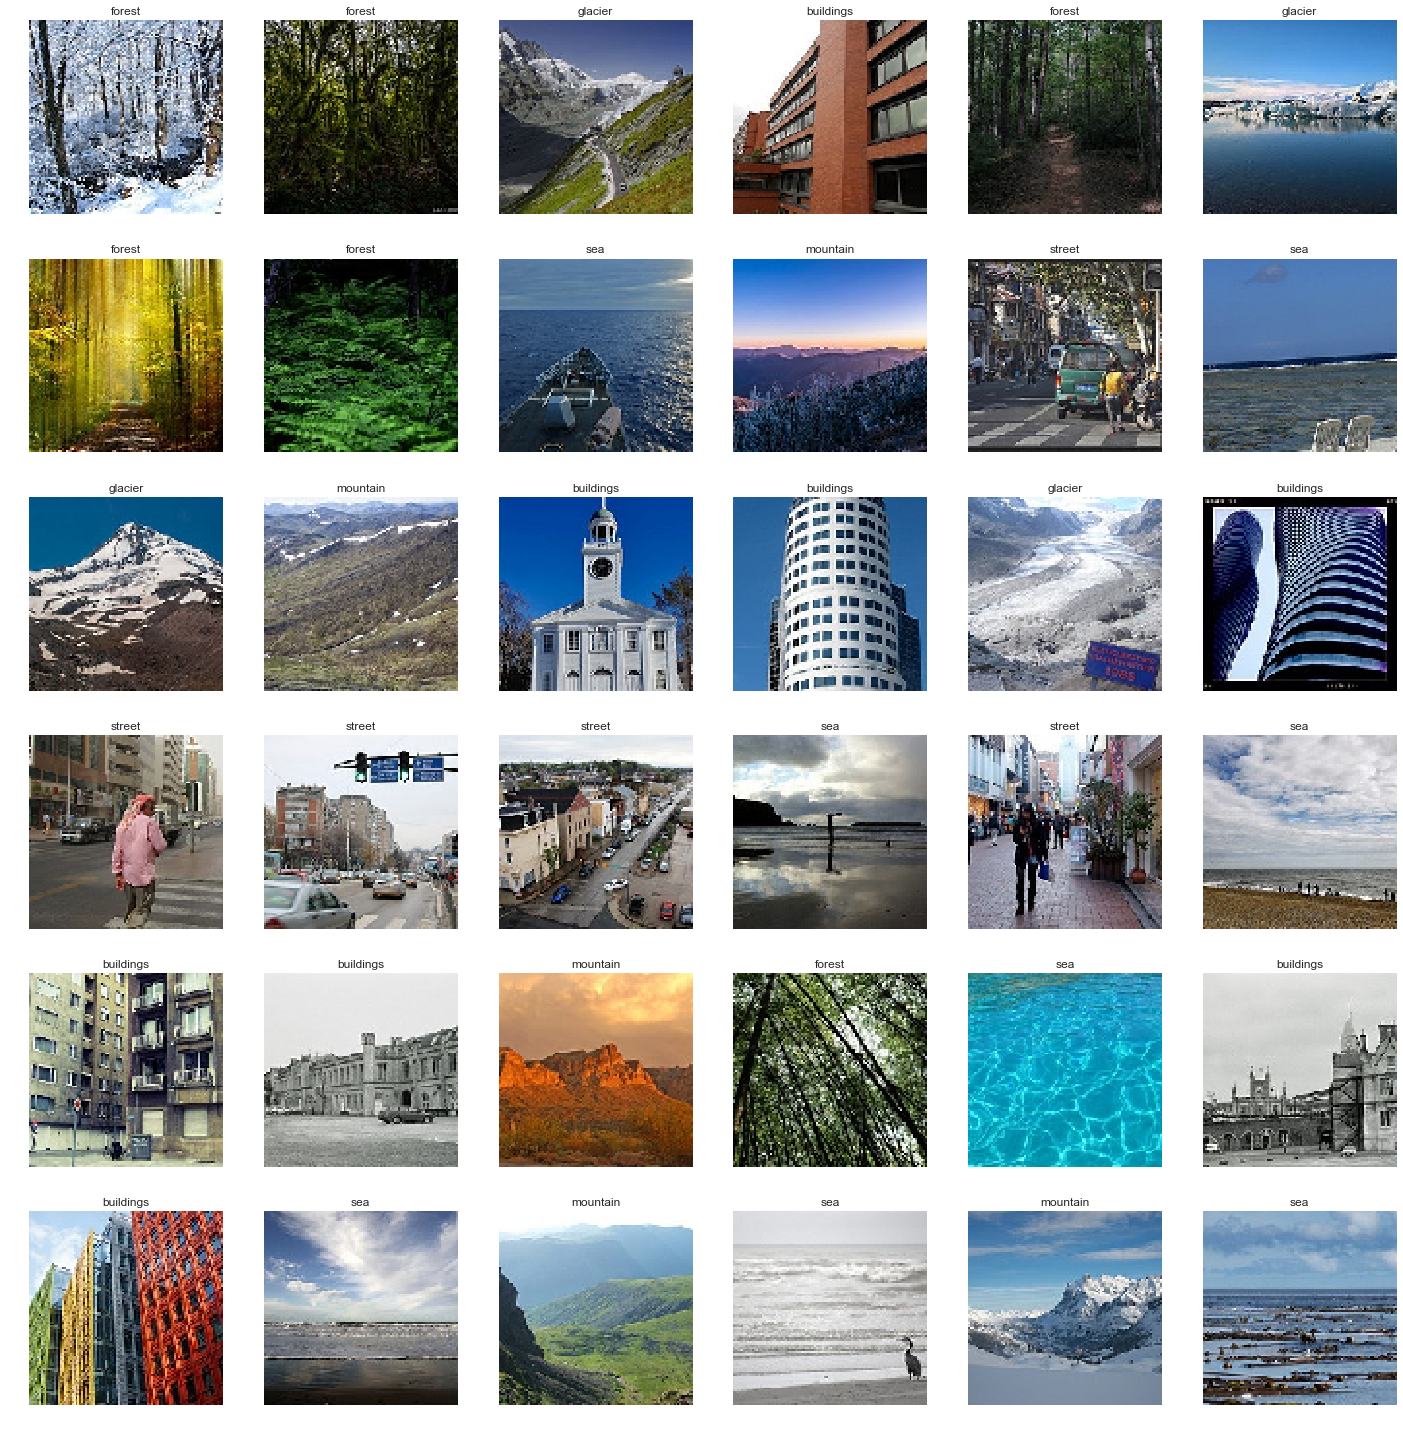

In [12]:
#Miramos unas cuántas imágenes y a que clase pertenecen.
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i]/255)   
    plt.axis('off')
    plt.title(getcode(y_train[i]))
    plt.tight_layout()

# Modelos <a class="anchor" id="two"></a>

Para empezar debemos pasar a arrays de numpy nuestros datos y reescalar las imagenes. Las dimensiones de cada foto corresponden a imágenes RGB (3 canales) con píxeles entre 0 y 255.

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = X_train/255
X_test = X_test/255
print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (14034, 100, 100, 3)
X_test shape  is (3000, 100, 100, 3)
y_train shape  is (14034,)
y_test shape  is (3000,)


En los dos modelos que construimos utilizamos accuracy como métrica (porcentaje de aciertos). La función de pérdida es "sparse_categorical_crossentropy", es la misma que "categorical_crossentropy" solo que el target no necesita estar en formato onehot-encoding. El optimizador es "adam", uno de los mejores del momento, es una mezcla entre descenso por gradiente estocástico con momentum y RSMProp (RSMProp optimiza de manera normalizada en cada axis del gradiente). Entrenamos sobre 20 epochs en cada modelo, con un batch size de 128 y un validation split de tamaño 0.2 sobre el total del train. 

Los modelos se componen en una serie de capas convolucionales, junto con capas maxpool. Al final de cada modelo añadimos las capas densas, acabando con una capa de salida que predice las probabilades de cada clase mediante la función de activación "softmax". En el modelo un poco más grande añadimos capas dropout para prevenir overfitting.

Veamos que resultados conseguimos con un modelo pequeño.

In [70]:
KerasModel = keras.models.Sequential([
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu',input_shape=(img_width, img_height,3)),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(40,kernel_size=(3,3),activation='relu'),    
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(50,activation='relu') ,       
        keras.layers.Dense(20,activation='relu') ,         
        keras.layers.Dense(6,activation='softmax') ,    
        ])
KerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(KerasModel.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 50)        1400      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 40)        18040     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 40)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1020      
__________

In [71]:
epochs = 20
trained = KerasModel.fit(X_train, y_train, epochs=epochs,batch_size=128,validation_split=0.20,verbose=1)

Train on 11227 samples, validate on 2807 samples
Epoch 1/20
11227/11227 [==============================] - 87s 8ms/step - loss: 1.2633 - acc: 0.4838 - val_loss: 1.1277 - val_acc: 0.5533
Epoch 2/20
11227/11227 [==============================] - 81s 7ms/step - loss: 0.9613 - acc: 0.6250 - val_loss: 0.9079 - val_acc: 0.6573
Epoch 3/20
11227/11227 [==============================] - 82s 7ms/step - loss: 0.8558 - acc: 0.6777 - val_loss: 0.8537 - val_acc: 0.6812
Epoch 4/20
11227/11227 [==============================] - 82s 7ms/step - loss: 0.7678 - acc: 0.7168 - val_loss: 0.7808 - val_acc: 0.7175
Epoch 5/20
11227/11227 [==============================] - 82s 7ms/step - loss: 0.7337 - acc: 0.7331 - val_loss: 0.7616 - val_acc: 0.7271
Epoch 6/20
11227/11227 [==============================] - 82s 7ms/step - loss: 0.6828 - acc: 0.7535 - val_loss: 0.7251 - val_acc: 0.7335
Epoch 7/20
11227/11227 [==============================] - 86s 8ms/step - loss: 0.6635 - acc: 0.7590 - val_loss: 0.6959 - val_acc:

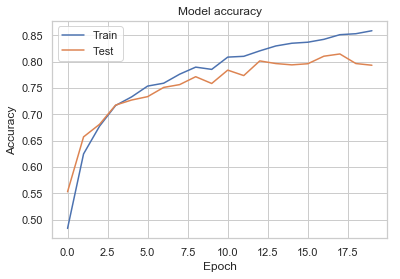

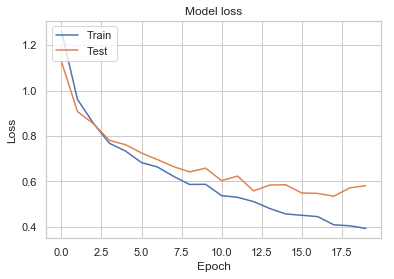

In [75]:
plt.plot(trained.history['acc'])
plt.plot(trained.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [74]:
ModelLoss, ModelAccuracy = KerasModel.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

3000/3000 [==============================] - 7s 2ms/step
Test Loss is 0.5717936221758525
Test Accuracy is 0.7940000001589457


Hemos conseguido con un modelo no muy complejo un 0.794 de test accuracy. Podíamos haber añadido más epoch, pero el overfitting se empezaba a notar. Repitamos los pasos con un modelo más complejo.

In [46]:
KerasModel = keras.models.Sequential([
        keras.layers.Conv2D(100,kernel_size=(3,3),activation='relu',input_shape=(img_width, img_height,3)),
        keras.layers.Conv2D(100,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(100,activation='relu') ,    
        keras.layers.Dense(50,activation='relu') ,        
        keras.layers.Dropout(rate=0.5) ,    
        keras.layers.Dense(20,activation='relu') ,        
        keras.layers.Dense(6,activation='softmax') ,    
        ])
KerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(KerasModel.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 100)       2800      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 96, 96, 100)       90100     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 100)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 22, 50)        45050     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               125100    
__________

En este modelo hemos pasado de 76 mil parámetros a 275 mil. Aquí si fuese posible sería interesante usar GPU. No es el caso.

In [47]:
%%time
epochs = 20
trained = KerasModel.fit(X_train, y_train, epochs=epochs,batch_size=128,validation_split=0.20,verbose=1)

Train on 11227 samples, validate on 2807 samples
Epoch 1/20
11227/11227 [==============================] - 932s 83ms/step - loss: 1.3619 - acc: 0.4211 - val_loss: 1.0852 - val_acc: 0.5415
Epoch 2/20
11227/11227 [==============================] - 894s 80ms/step - loss: 1.0803 - acc: 0.5642 - val_loss: 1.0195 - val_acc: 0.6031
Epoch 3/20
11227/11227 [==============================] - 888s 79ms/step - loss: 0.9745 - acc: 0.6188 - val_loss: 0.8413 - val_acc: 0.6548
Epoch 4/20
11227/11227 [==============================] - 893s 80ms/step - loss: 0.8671 - acc: 0.6726 - val_loss: 0.7962 - val_acc: 0.7032
Epoch 5/20
11227/11227 [==============================] - 891s 79ms/step - loss: 0.8068 - acc: 0.7054 - val_loss: 0.6881 - val_acc: 0.7364
Epoch 6/20
11227/11227 [==============================] - 886s 79ms/step - loss: 0.7437 - acc: 0.7370 - val_loss: 0.6187 - val_acc: 0.7841
Epoch 7/20
11227/11227 [==============================] - 886s 79ms/step - loss: 0.6721 - acc: 0.7665 - val_loss: 0.5

In [50]:
ModelLoss, ModelAccuracy = KerasModel.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

3000/3000 [==============================] - 64s 21ms/step
Test Loss is 0.5239449694156647
Test Accuracy is 0.8403333331743876


Con una red convolucional más grande hemos pasado de __0.79 a 0.84.__ El coste computacional se ha multiplicado por 10 (mirar tiempo de epochs en ambos modelos).

# Transfer Learning <a class="anchor" id="three"></a>

Vamos a realizar transfer Learning con el modelo MobileNet. Es un modelo bastante ligero. Como siempre que hacemos transfer learning solo entrenaremos las últimas capas de la red. 

Esta vez no usaremos el modelo "sequential" de keras. Vamos a usar la API Keras. Es muy intuitiva, solo hay que ir enlazando las capas. La API permite crear redes mucho más complejas, con saltos de capas, biridireccionales... 

In [58]:
from keras.applications import MobileNet
from keras.models import Model

base_model=MobileNet(weights='imagenet',include_top=False)
x=base_model.output
#Añadimos unas cuantas capas
x=keras.layers.GlobalAveragePooling2D()(x)
#x=keras.layers.Dense(256,activation='relu')(x) 
#x=keras.layers.Dense(64,activation='relu')(x) 
preds=keras.layers.Dense(6,activation='softmax')(x) 
model=Model(inputs=base_model.input,outputs=preds)
len(model.layers)

C:\Users\ian.delaoliva\AppData\Local\Continuum\anaconda3\envs\CV\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


89

In [59]:
for layer in base_model.layers:
    layer.trainable = False

In [60]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

In [61]:
%%time
model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
epochs = 20
trained = model.fit(X_train, y_train, epochs=epochs,batch_size=128,validation_split=0.20,verbose=1)

Train on 11227 samples, validate on 2807 samples
Epoch 1/20
11227/11227 [==============================] - 558s 50ms/step - loss: 0.9716 - acc: 0.6589 - val_loss: 0.5753 - val_acc: 0.7891
Epoch 2/20
11227/11227 [==============================] - 576s 51ms/step - loss: 0.4888 - acc: 0.8283 - val_loss: 0.5258 - val_acc: 0.8080
Epoch 3/20
11227/11227 [==============================] - 478s 43ms/step - loss: 0.4144 - acc: 0.8547 - val_loss: 0.5259 - val_acc: 0.8123
Epoch 4/20
11227/11227 [==============================] - 455s 41ms/step - loss: 0.3686 - acc: 0.8680 - val_loss: 0.5169 - val_acc: 0.8172
Epoch 5/20
11227/11227 [==============================] - 454s 40ms/step - loss: 0.3381 - acc: 0.8814 - val_loss: 0.5419 - val_acc: 0.8030
Epoch 6/20
11227/11227 [==============================] - 463s 41ms/step - loss: 0.3122 - acc: 0.8882 - val_loss: 0.5113 - val_acc: 0.8147
Epoch 7/20
11227/11227 [==============================] - 471s 42ms/step - loss: 0.3090 - acc: 0.8883 - val_loss: 0.4

KeyboardInterrupt: 

Hemos parado antes de que termine a proposito ya que el validation accuracy no estaba mejorando. 

In [45]:
#Con solo 5 epochs
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

3000/3000 [==============================] - 93s 31ms/step
Test Loss is 0.5564390602111816
Test Accuracy is 0.8003333331743876


Con solo 5 epoch hemos mejorado el resultado de la red convolucional simple. 

In [64]:
#10 epochs
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

3000/3000 [==============================] - 91s 30ms/step
Test Loss is 0.5615660025278727
Test Accuracy is 0.8036666666666666


Con 10 epochs hemos visto que el modelo empeza a realizar overfitting, con lo cual lo hemos parado manualmente. El resultado es prácticamente el mismo que el de 5 epochs. Esto es habitual en transfer learning debido a que solo estamos entrenando la última capa de la red y en este caso es únicamente la capa de predicción.

Si estuviesemos entrenando más parámetros de la red podríamos haber usado técnicas de regularización como batch normalization y early stopping para prevenir el overfitting.  

# Como aprenden las redes neuronales <a class="anchor" id="four"></a>

En este apartado vamos a usar la segunda red convolucional que hemos creado para visualizar como aprende la red. Estas técnicas están sacadas del libro de Francois Chollet, "Deep Learning with Python".

In [65]:
KerasModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 100)       2800      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 96, 96, 100)       90100     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 100)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 22, 50)        45050     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               125100    
__________

In [66]:
KerasModel.layers

Vemos que en nuestro modelo tenemos 10 capas. Nos interesan la salida hasta la última capa convolucional, una vez que pasamos a capas densas no podemos visualizar nada.

In [88]:
from keras import models
layer_outputs = [layer.output for layer in KerasModel.layers[:8]]
#Modelo que se fijará en los outputs de cada layer. Sirve para guardar las salidas de cada capa que nos interesen.
activation_model = models.Model(inputs=KerasModel.input, outputs=layer_outputs) 

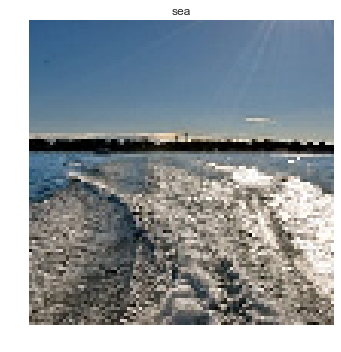

In [92]:
#Escogemos una imagen al azar.
plt.figure(figsize=(5,5))
for n , i in enumerate(list(np.random.randint(0,len(X_train),1))) : 
    plt.subplot(1,1,n+1)
    plt.imshow(X_train[i])   
    plt.axis('off')
    plt.title(getcode(y_train[i]))
    plt.tight_layout()

Escogemos una foto y realizamos una predicción.

In [94]:
foto=X_train[i]
foto.shape
fot=foto.reshape(1,100,100,3) #reshape necesario para poder entrar a la red

(100, 100, 3)

In [96]:
activations = activation_model.predict(fot)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 98, 98, 100)


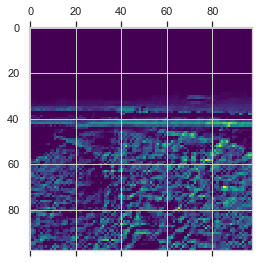

In [103]:
j=9 #Esto índica la capa que vamos a visualizar
plt.matshow(first_layer_activation[0, :, :, j], cmap='viridis')

# Heatmaps <a class="anchor" id="five"></a>

Una breve explicación es:

This general category of techniques is called class activation map (CAM) visualization,
and it consists of producing heatmaps of class activation over input images. A class activation
heatmap is a 2D grid of scores associated with a specific output class, computed
for every location in any input image, indicating how important each location is with respect to the class under consideration. For instance, given an image fed into a dogsversus-
cats convnet, CAM visualization allows you to generate a heatmap for the class
“cat,” indicating how cat-like different parts of the image are, and also a heatmap for the
class “dog,” indicating how dog-like parts of the image are.

Veamos el ejemplo del libro.

In [6]:
#Cargamos la red con los pesos entrenados VGG16
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [5]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
img_path = './Images/tigres.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

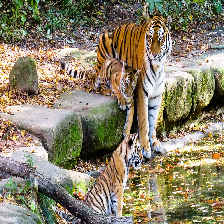

In [7]:
img

In [8]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02129604', 'tiger', 0.9487974), ('n02123159', 'tiger_cat', 0.043646175), ('n02391049', 'zebra', 0.00096870953)]


Vemos que el modelo predice tigre con un 0.94.

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
np.argmax(preds[0]) #Miramos que indice pertenece la clase tigre.

292

In [10]:
tiger_output = model.output[:, 292] #Nos quedamos con la salidas pertenecientes a la clase predicha
last_conv_layer = model.get_layer('block5_conv3') #Escogemos la última capa convolucional de la red

Aquí viene la magia. 
+ Primero calculamos los gradientes respecto a la clase tigre del output de la última capa convolucional. 
+ A continuación calculamos la media de estos gradientes a través de los tres axis.
+ Definimos el acceso de manera iterativa al anterior valor y a la salida de la última capa de convolucional de la red.
+ Después multiplicamos cada canal en el "feature map array" por como de importante es ese canal respecto a la clase tigre. En este caso tenemos 512 canales (fijarse en las dimensiones de esta capa convolucional). 
+ Por último calculamos la media a través de todos los canales, esto es el __heatmap de la clase de activación__.

In [11]:
grads = K.gradients(tiger_output, last_conv_layer.output)[0] 
pooled_grads = K.mean(grads, axis=(0, 1, 2))
#Definimos el acceso a las cantidades que hemos definido arriba para una imagen dada:
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
#Obtenemos los valores para la imagen dada:
pooled_grads_value, conv_layer_output_value = iterate([x]) 
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

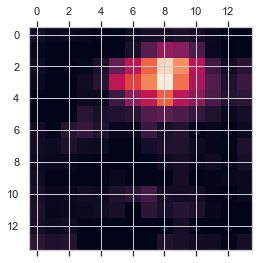

In [139]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Ya solo falta superponer este heatmap sobre nuestra foto. Nos ayudamos del paquete cv2 (mejor paquete para cualquier preprocesamiento de imágenes). Leemos la imagen original. Cambiamos el tamaño del heatmap a la de nuestra imagen. Escalamos a 0-255. Sumamos el heatmap por un factor de 0.4 a nuestra imagen. La guardamos y la ploteamos.

In [140]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./Images/superposed.jpg', superimposed_img)

True

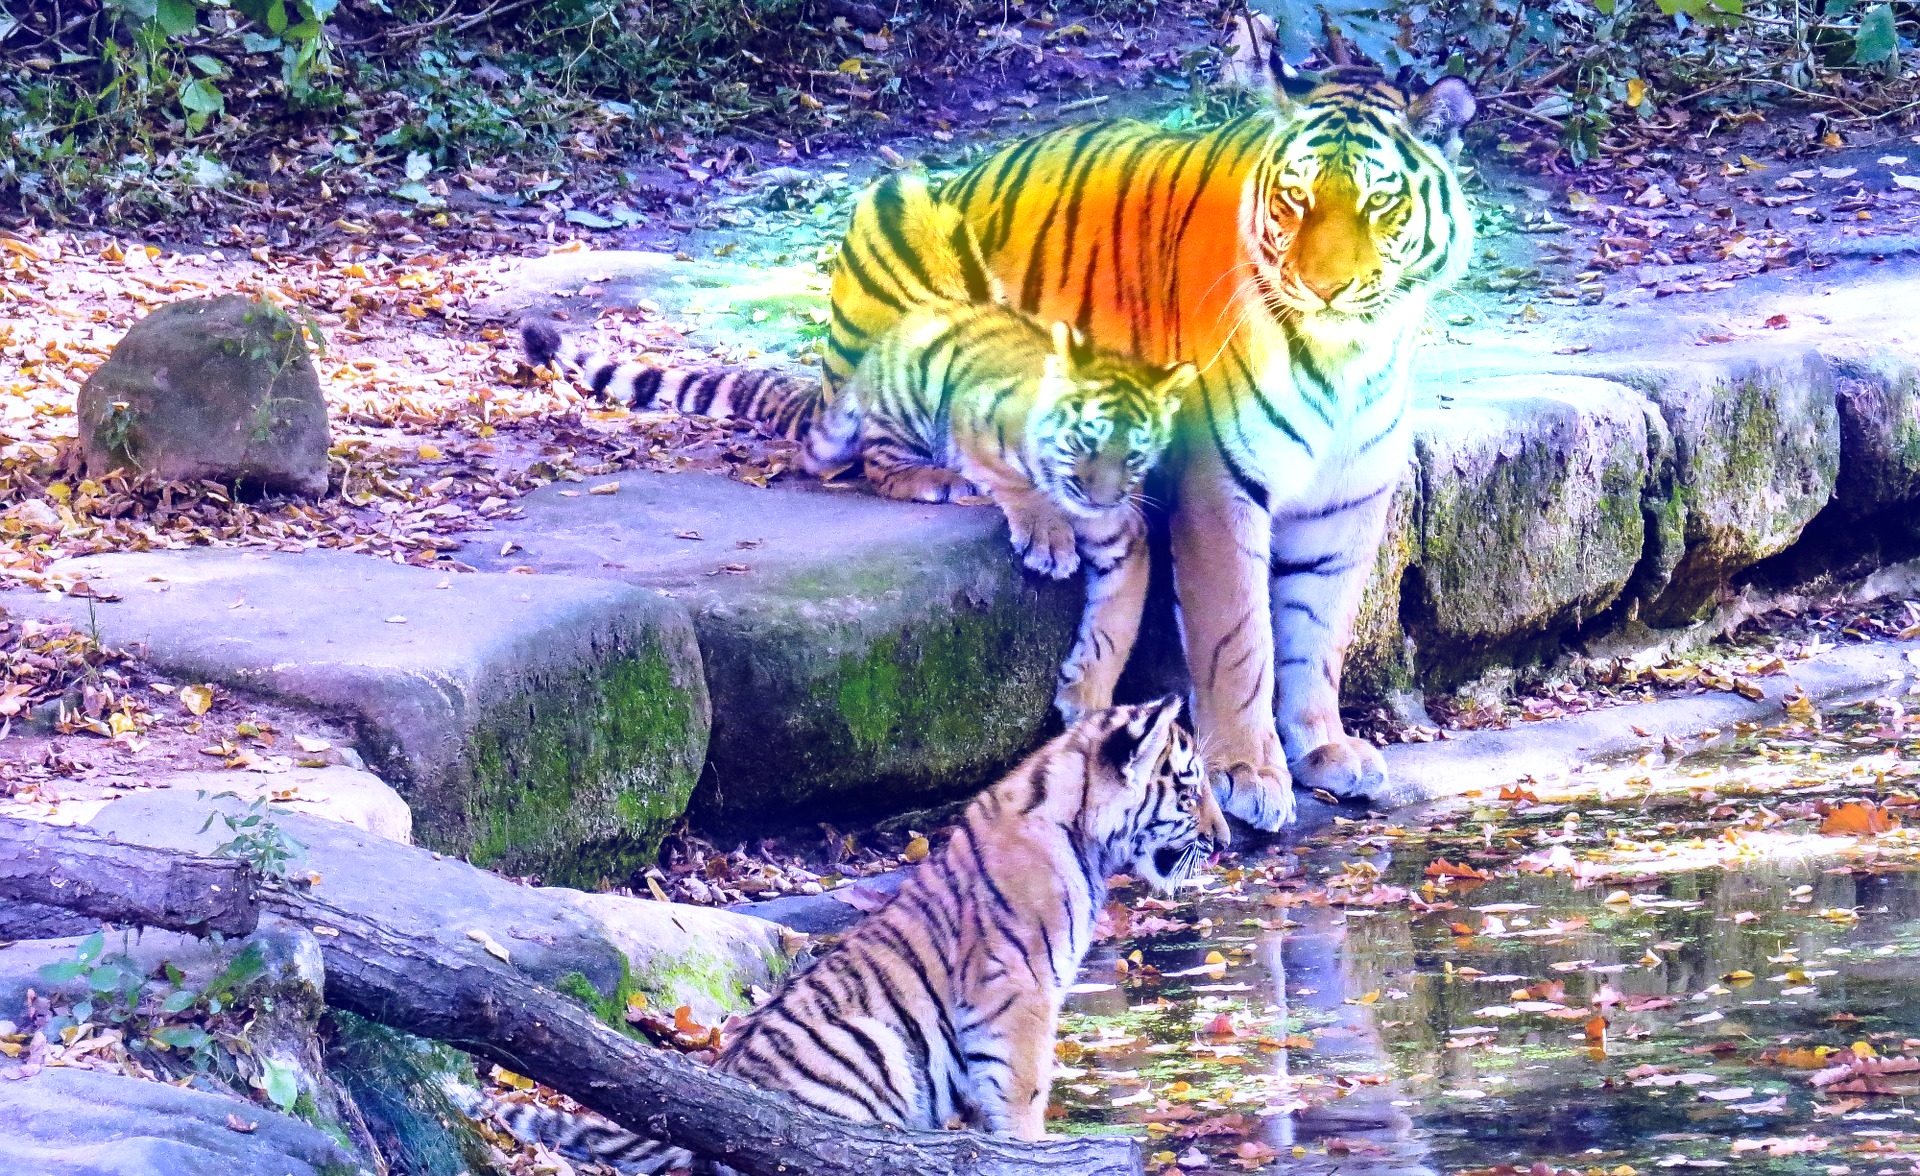

In [141]:
superposed = image.load_img("./Images/superposed.jpg")
superposed

### Con nuestra red

Repetimos el proceso explicado arriba.

In [123]:
KerasModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 100)       2800      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 96, 96, 100)       90100     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 100)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 22, 50)        45050     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               125100    
__________

In [191]:
img_path = './Datasets/seg_pred/121.jpg'
img = image.load_img(img_path, target_size=(100, 100))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [192]:
preds = KerasModel.predict(x)
print('Predicted:', preds)

Predicted: [[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.35694944e-33 1.02859043e-25]]


In [193]:
np.argmax(preds[0])

0

In [194]:
output = KerasModel.output[:, 0]
last_conv_layer = KerasModel.get_layer('conv2d_12')

In [195]:
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([KerasModel.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(50):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

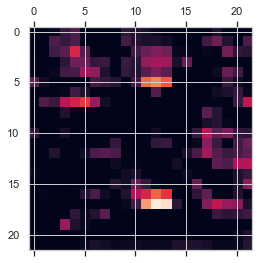

In [196]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [197]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./Images/superposed_prueba.jpg', superimposed_img)

True

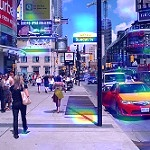

In [12]:
superposed = image.load_img("./Images/superposed_prueba.jpg")
superposed

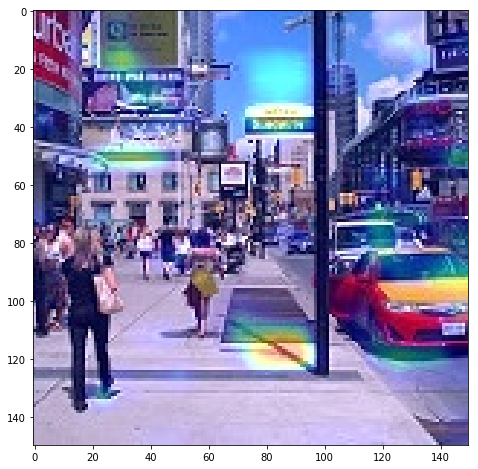

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(superposed)